# Hackacity 2024
## [SOLUTION NAME]
#### Team: PLICity
#### Authors:
- José Cabeda
- Lirielly 
- Pedro Machado
- Igor Carvalho

# Instructions
- The purpose of this notebook is to provide a detailed description so that the technical and business jury can have an overview of the technical and non-technical aspects and how they interconnect.
- To use the template, you must make a copy and fill in the team name and the challenge title.
- The cells containing the instructions should be deleted, but all headers must be kept.
- All technical information should be included in this report (e.g., code, queries, graphs, tools used, parameters, etc.). If necessary, additional files can be added to the OneDrive folder, with references to those files included in this report.

# Tip
- The technical and business jury will need to evaluate several notebooks, so it’s important to maintain a clear line of thought within the notebook without overloading it with too many similar graphs or visuals that do not add value to the work. On the other hand, it’s important to show that the work done is thorough.
- Therefore, we recommend using the annex section to include code that was produced along with its description but might be unnecessary noise for the jury (e.g., tested models that didn’t work, EDA with very similar results between variables, etc.).


# 1 - Introduction


The wifi acess data provides us with a way to track the mobility of the citizens. According to the paper A Survey on Privacy in Human Mobility "human mobility data can be used for different scopes such as urban traffic management, urban planning, urban pollution estimation, etc". With the rise of AI many use cases devolve around having a good dataset without biases and with relevant data.

In this work we:

- Propose an solution which enables users knowing about their data usage and processing
- Enable users to request data deletion
- Propose how to generate a synthetic dataset for these types of uses cases, also enabling to share less risk datasets with the community
- Propose the usage of this dataset to predict the access points where the number of sessions surpasses a given threshold
- Prove that this synthetic data can be used for our model, performing quality checks between models with synthetical an non-synthetical data

Furthermore we provide an analysis that the dataset, even if anonymised, could be used for individual tracking by reverse engineering the location of the datasets based on the number of sessions in a given day, by matching with main events in the city of Porto. The same shouldn't occur with the synthetized dataset.

![Solution overview](img/sol_overview.png)

# 2 - Possible threat analysis before anonymization

### Instructions:
This section should cover a threat analysis of the dataset from the privacy perspective and it's quantification.

Important notes:
- Only this section is evaluated for the data privacy award;
- No code is needed for this section;
- A good quantification of the threat is valuade by the jury;
- Include any references that is important.

### Risk Assesstment
The challenge provides us with two separate datasets. The access points and the wifi_locations. Focusing on these we find the following threats.

1. Detailed Movement Tracking
A possible issue with the wifi access without anonymization is that we can hypotheticaly track a singular user. An attacker could piece together a user's daily routine by:
  - Tracking consistent MAC addresses on the wifi sessions
  - Analyzing connection timestamps (`acctstarttime` and `acctsessiontime`)
  - Mapping access point locations by correlating with the `callingstationid`

For example consider the following
  ```
  User consistently connects to:
  - 7:30 AM: Access Point near home
  - 8:00 AM: Access Point near workplace
  - 12:30 PM: Access Point in lunch area
  - 6:00 PM: Access Point near home again
  ```

- This pattern reveals:
  - Home location
  - Work location
  - Daily routine
  - Potentially sensitive personal information

2. Data Correlation Risks

With the dataset and the identification of the dataset, it's possible for other entities to cross-reference:
  - with public social media
  - Location-based services (i.e. strava)
  - Other open datasets

With this dataset it's possible to:
  - target advertisments (given a mac address present ads on restaurants or shops it usually goes by)
  - allow potential stalking
  - enable social engineering attacks (i.e. answer questions like what is the your favorite restaurant?)

# Risk Assessment Scorecard

There are 3 possible values (none -0 | low -1  | high - 2). On top of the risks above we define the following categories to help track the impact of having the dataset available:

- Data Breach Impact
- Legal and Regulatory Compliance
- Technical Safeguards
- Monitoring and Auditing
- User Education and Awareness
- Incident Response Plan

# Risk Assessment Scorecard

| Risk Category                   | Status |
|-----------------------------    |--------|
| Detailed Movement Tracking      | 2      |
| Data Correlation Risks          | 2      |
| Data Breach Impact              | 2      |
| Legal and Regulatory Compliance | 2      |
| Technical Safeguards            | 2      |
| Monitoring and Auditing         | 2      |

Risk score: 12/12

## Mitigation Strategies 

For Detailed Movement Tracking and Data Correlation Risks we propose the following mitigation strategies:

1. **Detailed Movement Tracking**:
   - Hashing MAC addresses (`callingstationid`)
   - Create random session IDs (`acctsessionid`)

These techniques allow to remove the direct connection between the access points and the wifi accesses datasets.

2. **Data Correlation Risks**:

- Reduce detailed location information (i.e. access points coordinates are approximated)
- Generalize timestamps (i.e. remove minutes or change date)

3. **Data Breach Impact**

- Develop and maintain an incident response plan
- Include steps for notifying affected individuals and regulatory authorities

4. **Legal and Regulatory Compliance**:

- Clear user consent for data collection
- Opt-out mechanisms
- Detailed privacy policy

Although it doesn't mitigate the risks of approved data this enables the dataset to be given only by consenting users and in this way follow the GDPR which states that we can only store data a given user consents on.

5. **Technical Safeguards**:
- Implement encryption for data at rest and in transit
- Use secure access controls and authentication mechanisms

6. **Monitoring and Auditing**:
- Regularly monitor access to the data and audit logs
- Implement intrusion detection systems



# 3 - Anonymization process

### Instructions

Based on the previous threat assesment, propose any anonymization techniques you might find helpful.

Include all the code and proof needed that the threat has been mitigated.

## Synthetic data for ML
Considering the techniques which have already been applied to the dataset provided to us we have an hypothesis that we can potentially reverse engineer the relation between the access points by correlating across different datasets and link to real identities through additional context. 

For example in this work we propose the usage of datasets with the Porto city events and the university of Porto events and correlate them with access outliers. (i.e there's an access point in Inesc near FEUP, and given a couple of events at this place, if they closely correlate to the same dates of outliers we can say with confidence that the anonymised callingstationid refers to the given access point).

Some existing event datasets are:
- Cultural calendar of porto: https://opendata.porto.digital/dataset/8f4316c7-aafe-488f-a8b0-5e721ae37637/resource/351[…]95011584?activity_id=be273578-39f4-4c76-ae1d-db515d9f7362
- university of porto calendar: https://sigarra.up.pt/up/pt/web_base.gera_pagina?p_pagina=calend%c3%a1rio%20escolar%20da%20universidade%20do%20porto


In [36]:
"""
In this section we will be using the DuckDB database to quickly read the input data.
"""
import duckdb
import pandas as pd

with duckdb.connect(database='./data.db', read_only=False) as con:
   wifi_sessions_data = con.execute("select * from wifi_sessions").fetch_df()

wifi_sessions_data = wifi_sessions_data.drop(columns='column0')

df_wifi = pd.read_csv("data/hackacity_wifi_data.csv")



In [37]:
from process import CategoricalEncoder, PostProcess
"""
This script processes WiFi session data by performing the following steps:
1. Converts the 'acctstarttime' column from nanoseconds to seconds.
2. Fills missing values in the dataset with the mode of each column.
3. Encodes categorical columns using a custom CategoricalEncoder.

Modules:
    process: Contains the CategoricalEncoder and PostProcess classes.

Constants:
    SEED (int): Random seed for reproducibility.

Variables:
    wifi_sessions_data (DataFrame): The input WiFi session data.
    X (DataFrame): A copy of the input data with missing values filled.
    CAT_COLS (list): List of categorical columns to be encoded.
    cat_encoder (CategoricalEncoder): An instance of the CategoricalEncoder class.
    X_encoded (DataFrame): The encoded DataFrame after applying the categorical encoding.
"""
SEED = 42

wifi_sessions_data['acctstarttime'] = wifi_sessions_data['acctstarttime'].apply(lambda x: x.timestamp())





 # Divide by 10^9 to convert from nanoseconds to seconds

X = wifi_sessions_data.copy()

X = X.apply(lambda col: col.fillna(col.mode()[0]))

CAT_COLS=['acctsessionid', 'callingstationid', 'calledstationid', 'calledstation_ssid']


cat_encoder = CategoricalEncoder(categorical_columns=CAT_COLS)
cat_encoder.fit(X)
X_encoded = cat_encoder.transform(X)
X_encoded

,acctsessionid,acctstarttime,upload,download,acctsessiontime,callingstationid,calledstationid,calledstation_ssid
0,6543791,1726668000,0,0,0,126221,244,1
1,2992450,1726664400,0,0,0,413829,135,1
2,3715121,1726124400,0,0,6,312763,206,0
3,1730167,1726102800,2,30,32,199339,175,1
4,531229,1726106400,0,1,6,278388,100,1
...,...,...,...,...,...,...,...,...
13983113,728134,1726660800,0,0,0,395645,32,0
13983114,948633,1726102800,0,0,0,384999,193,0
13983115,4821705,1726113600,0,0,6,303431,227,0
13983116,2681722,1726117200,3,6,6,488592,213,1


In [ ]:
from sklearn.mixture import GaussianMixture

# Train GMM
gmm = GaussianMixture(n_components=5, random_state=SEED)
gmm.fit(X_encoded)

In [ ]:
import pandas as pd
# Generate synthetic samples
synthetic_data = gmm.sample(n_samples=len(X_encoded))[0]
synthetic_data_df = pd.DataFrame(synthetic_data, columns=X_encoded.columns)
synthetic_data_df.head()

/Users/jose.cabeda/Git/hackacity/.venv/lib/python3.13/site-packages/sklearn/mixture/_base.py:436: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))


,acctsessionid,acctstarttime,upload,download,acctsessiontime,callingstationid,calledstationid,calledstation_ssid
0,2.894302e+05,0.000171,-0.001964,0.000242,42218.269112,356490.104256,90.678046,0.075464
1,6.641767e+06,0.001412,-0.000458,0.001466,14713.469516,165667.467402,110.682754,-0.190253
2,3.195694e+06,-0.000432,-0.000225,-0.000601,39974.229929,42662.683555,128.430020,-0.264568
3,4.482362e+06,0.000938,-0.002136,0.000209,65601.704266,511507.075714,233.422574,0.631714
4,5.879036e+06,0.000194,-0.000760,-0.001479,106554.438706,274799.555511,124.660680,0.325168


In [ ]:
"""
In this section we will be using the PostProcess class to post-process the synthetic data from numeric values into categorical values that are similar to the original data.
"""
post_process = PostProcess(categorical_columns=CAT_COLS, original_data=X_encoded)
synthetic_data_df = post_process.transform(df   =synthetic_data_df)

synthetic_data_df=cat_encoder.decode(synthetic_data_df)
synthetic_data_df

Decoding column acctsessionid
Decoding column callingstationid
Decoding column calledstationid
Decoding column calledstation_ssid


,acctsessionid,acctstarttime,upload,download,acctsessiontime,callingstationid,calledstationid,calledstation_ssid
0,0b21b7e9bd11b051bd8dadcf617be18cdad908a9863c3f...,0,0,0,42218.269112,b832e37e096f366cff1943f6482f1a25e272641b00a4c0...,5646124e6a2972e4c8e49aefd934d3f7609adcf99fb297...,Porto. Free Wi-Fi
1,ffc315fc56524819a0a8a3d149e9cb2bece91a1e5519bf...,0,0,0,14713.469516,557fb223363366c336d770fd2f5dfd38f9fb1c0ff29ccb...,66989bc1b3c3cf44f2db3bd6d1f52f7bdcf24f8dfd8bf3...,Porto. Free Wi-Fi
2,7b0b5ec8b78ffb6e8ecb6009cff7896366796499cffb37...,0,0,0,39974.229929,15f89555710b0e7f0002492df7436ef4699329dbb4a945...,72e6bc264a984ebc78efaceea1dd34f83af566c3bfb350...,Porto. Free Wi-Fi
3,ac858aa39d8495fbce3c48cc3cecee52c8ba74d3c0bacd...,0,0,0,65601.704266,ffffef056751777a6c25898f8032327cb0b008bac5605e...,d724f6a8e5fa8d84e8d8bd20f64e23c05c8d0aca821661...,eduroam
4,e25d038e6c9189a6c8a17d551b2868a888f0de626cb6ac...,0,0,0,106554.438706,8e0e6668b67b7d719e0967c9340c4cdb5e173459626145...,712ab2af64efb9bc13a82847623bfc86f0b70a625066b6...,Porto. Free Wi-Fi
...,...,...,...,...,...,...,...,...
13983113,6d5c25a698007bdc39dfea0aeb0b234d2e28781aeffbeb...,0,0,0,0.000000,4b2c06839f588930c04cdaeb2daf494b75c2b03d74fd6f...,000a9b5f3e9924b838334ddc856fb44e865abff86f6ef2...,eduroam
13983114,a847337a9161165c54763a9df6790bdea7b8fdc0751ce7...,0,0,0,4.255738,f699a63af42aab88f8d7289dee9b185de13df73bbb1bf3...,712ab2af64efb9bc13a82847623bfc86f0b70a625066b6...,Porto. Free Wi-Fi
13983115,730c73b05113b54ab47564e7e9595fdc79ca8bb0d2a089...,0,0,0,0.867229,4fe8081c90fe9464207deb41ff7effeb67ae79694006f6...,99f2a505a6dd020059758ce68eb487950642769def00d9...,Porto. Free Wi-Fi
13983116,d150205e68a36d3a1c95276e05196fde9fd3be34529993...,0,0,0,4.361421,75c89d8c409c8dbea5d483bd29c4f05e219029494a3a25...,000a9b5f3e9924b838334ddc856fb44e865abff86f6ef2...,Porto. Free Wi-Fi


In [ ]:
wifi_sessions_data.describe()

,acctstarttime,upload,download,acctsessiontime
count,13983118.0,1.398312e+07,1.398312e+07,1.212133e+07
mean,0.0,2.015751e+00,8.959031e+00,6.413402e+03
std,0.0,4.259514e+01,1.386290e+02,2.545350e+04
min,0.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.0,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.0,0.000000e+00,0.000000e+00,4.000000e+00
75%,0.0,0.000000e+00,1.000000e+00,7.000000e+00
max,0.0,6.018500e+04,2.105490e+05,2.202470e+05


# 4 - Possible threat analysis after anonymization

### Instructions

Not all solutions are perfect - Do a threat analysis and compare the threats before and after your solution.

After the anonymization of the data we can consider 3 different stages:

1. Data is anonymized
2. Processes are implemented
3. Synthetic dataset is provided 

Given these stages we have the following score cards:

# Data is anonymized

Score: 10/12

| Risk Category                   | Status |
|-----------------------------    |--------|
| Detailed Movement Tracking      | 1      |
| Data Correlation Risks          | 1      |
| Data Breach Impact              | 1      |
| Legal and Regulatory Compliance | 2      |
| Technical Safeguards            | 2      |
| Monitoring and Auditing         | 2      |

# 2 - Processes are implemented

Score: 6/12

| Risk Category                   | Status |
|-----------------------------    |--------|
| Detailed Movement Tracking      | 1      |
| Data Correlation Risks          | 1      |
| Data Breach Impact              | 1      |
| Legal and Regulatory Compliance | 1      |
| Technical Safeguards            | 1      |
| Monitoring and Auditing         | 1      |

# 3 - Synthezized data is provided

Score: 2/12

| Risk Category                   | Status |
|-----------------------------    |--------|
| Detailed Movement Tracking      | 0      |
| Data Correlation Risks          | 0      |
| Data Breach Impact              | 0      |
| Legal and Regulatory Compliance | 1      |
| Technical Safeguards            | 1      |
| Monitoring and Auditing         | 1      |

# 5 - Data potential and analysis

### Instructions

It is typical that during an anonymization process, there is a loss of value in terms of insights. In this section, explore the other side of the scale - What can still be done with the data that is processed and why is the risk above justifiable taking into account the potential return?

Specifically, try to imagine yourself as the city's analytics team, which uses this data to gather conclusions about the city's state and flow and try develop and demonstrate what results and analyses can be done. You can use the given data plus optionally any other data sources. If you complement with additional datasets, be it from the city Open Data Portal (https://opendata.porto.digital) or other datasets, make sure you cite and reference them explicitly.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
sns.set_theme(style="dark", rc={'figure.figsize':(11,8)})

df_wifi = df_wifi[(df_wifi.acctsessiontime != 0) & (~df_wifi.acctsessiontime.isna())]

df_wifi["acctstarttime"] = pd.to_datetime(df_wifi["acctstarttime"])
df_wifi["date"] = df_wifi["acctstarttime"].apply(lambda x: x.date())
df_wifi["hour"] = df_wifi["acctstarttime"].apply(lambda x: x.hour)
df_wifi["month"] = df_wifi["acctstarttime"].apply(lambda x: x.month)

# monthly session sum ap
# Configuração para desativar a notação científica
pd.set_option('display.float_format', '{:.0f}'.format)
df_wifi.groupby(['calledstationid', 'month'], as_index=False)['acctsessiontime'].sum().sort_values(by='acctsessiontime', ascending=False)

,calledstationid,month,acctsessiontime
78,4cad16c07e8c4d222c35d87e0e91ca7f748373f1733a74...,1,2873988465
64,4430c37124a740cbd88faa185d3213254c4d45282a21e2...,1,2622580736
27,13795871cdbad092bb55f6f6fafcb8fac0cdcc6a68756d...,1,2304251841
2,01b7675673222f705ae8a4d45494d68ae6be119280eee9...,1,2088309693
275,fb635831ddca59a6749331693fa8058d5eeddc26eff8af...,1,2082921047
...,...,...,...
270,f75c66d36ed3329baa17382f5d07805ce8541f076b6ab3...,1,7857
184,ae7f85c95c69f233aa29a733e2362e0820e9da24a8ef09...,1,6847
83,4faaf8c6bbcceb3046fae9b9ee1f6135e89f84af9cad52...,1,4536
187,afd31b2b95e134a7888a540395f4b122969acdb2eb676b...,1,3173


In [ ]:
# monthly session sum per user and ap
df_wifi.groupby(['callingstationid', 'calledstationid', 'month'], as_index=False)['acctsessiontime'].sum().sort_values(by='acctsessiontime', ascending=False)

,callingstationid,calledstationid,month,acctsessiontime
673693,30519f9ec479c213fba27de8cecabbe743561ba61de0ac...,3c3d76861294fc3cc91f24bb4371475d70d7c031098fb6...,1,205186347
673694,30519f9ec479c213fba27de8cecabbe743561ba61de0ac...,699e73a48d40a6bfa12c823b48f627f6afe8c007efae13...,1,108285858
3423187,f63d843d48d0a433a2fddae8e06a182b4ed29545b55354...,1f0e40ed226098605a8b5ba0fb68b628913aa12f56c899...,1,99860077
738025,34ff900bff7e897ffdc89938f3fa8246f6532c74e9c126...,c77fc7796f65ed7912495d33dab3e9e72c098850a458bd...,1,79541936
720140,33a4da5c88fd87d6a599b67d274c6d31556345b5745285...,d975d47523a8cf49897135f4fecedb30b8edc4620f4944...,1,77406845
...,...,...,...,...
2072372,9552a97df08295bc9abd9516e60e815c6fa083c5be067f...,71356742cba9643b7ac2be2411b3bfe66f89ec664847a5...,1,1
2566869,b8a57f40ad800433ec7b1d1dc7acc1bf0534b409497d13...,b88058e804df91821218cfbafff1f73fb51a2df116dfe7...,1,1
2566868,b8a5685f4d7b3caf8d9154bb8b31ecef39d8bb1762a181...,fb3d5a9e87533447bbd2bbe3c635020977d4f8907cbf9f...,1,1
1216236,574e85431fe8e7a31054ca72f281b53037e099cc8ad087...,2891d2862c2b603d136c41db8c02b9814e621c7129d18a...,1,1


In [ ]:
# mean of unique users per aps during july, august and september 2024
df_wifi[df_wifi.month.isin([7, 8, 9])].drop_duplicates(subset=['callingstationid', 'calledstationid', 'month']).groupby(['calledstationid', 'month'], as_index=False)['callingstationid'].count().groupby('calledstationid', as_index=False)['callingstationid'].mean().sort_values(by='callingstationid', ascending=False)[:10]

,calledstationid,callingstationid


In [ ]:
# number of access per user in a day
df_wifi.groupby(['callingstationid', 'calledstationid', 'date'], as_index=False)['calledstationid'].count().sort_values(by='calledstationid', ascending=False)

,callingstationid,date,calledstationid
3005364,d8249cbd1476ed4ed03fc224d99bb901a133ad9ad2decc...,1970-01-01,4448
2123217,990ced9a798f0182f7a6959c7c69a26311e119421abf28...,1970-01-01,4382
1655042,7702994bb3979a85e771fac5ef44a361469d63c0454c37...,1970-01-01,4373
2801518,c9991033c7a00d1c7b797352d279a68163e5849ae94275...,1970-01-01,4373
1478340,6a53297fcb36f17c8c6396f810a452e9a205529900772a...,1970-01-01,4372
...,...,...,...
2003740,904e3ef47a1e395ab5d1ab35600d488c6271982a449e09...,1970-01-01,1
2003739,904e3ef47a1e395ab5d1ab35600d488c6271982a449e09...,1970-01-01,1
2003738,904e3ef47a1e395ab5d1ab35600d488c6271982a449e09...,1970-01-01,1
2003737,904e3ef47a1e395ab5d1ab35600d488c6271982a449e09...,1970-01-01,1


/var/folders/_6/6k8mw_7533g5qgphdzcj69t00000gp/T/ipykernel_21933/2616862855.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['calledstationid'] = pd.Categorical(


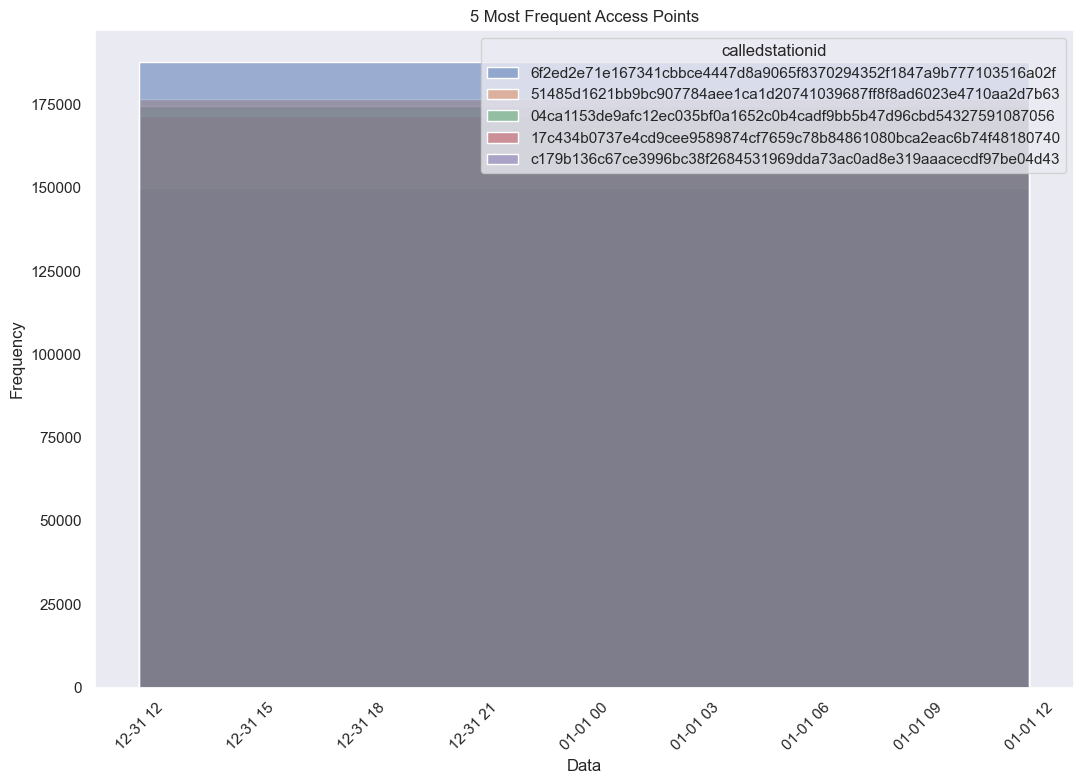

In [ ]:
top_5_calledstationids = df_wifi['calledstationid'].value_counts()[:5].index
filtered_df = df_wifi[df_wifi['calledstationid'].isin(top_5_calledstationids)]

# Contar as frequências em your_hue_column e ordenar
hue_order = filtered_df['calledstationid'].value_counts().index

# Converter your_hue_column para uma categoria ordenada
filtered_df['calledstationid'] = pd.Categorical(
    filtered_df['calledstationid'],
    categories=hue_order,
    ordered=True
)

# Plotar o histograma com o hue ordenado
sns.histplot(
    data=filtered_df,
    x='date',
    hue='calledstationid',
    bins=90,
    kde=False
)

# Configurações do gráfico
plt.title("5 Most Frequent Access Points")
plt.xlabel("Data")
plt.ylabel("Frequency")
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo X, se necessário
plt.tight_layout()
plt.show()

In [ ]:
top_1_calledstationids = df_wifi['calledstationid'].value_counts()[1:2].index
filtered_df = df_wifi[df_wifi['calledstationid'].isin(top_1_calledstationids)]

# Contar as frequências em your_hue_column e ordenar
hue_order = filtered_df['calledstationid'].value_counts().index

# Converter your_hue_column para uma categoria ordenada
filtered_df['calledstationid'] = pd.Categorical(
    filtered_df['calledstationid'],
    categories=hue_order,
    ordered=True
)

# Plotar o histograma com o hue ordenado
sns.histplot(
    data=filtered_df,
    x='date',
    hue='calledstationid',
    bins=90,
    kde=False
)

# Configurações do gráfico
plt.title("Most Frequent Access Points")
plt.xlabel("Data")
plt.ylabel("Frequency")
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo X, se necessário
plt.tight_layout()
plt.show()

In [ ]:
# plot of the most frequent access point in the most accessed days
top_1_calledstationids = df_wifi['calledstationid'].value_counts()[1:2].index
filtered_df_2 = df_wifi[df_wifi['calledstationid'].isin(top_1_calledstationids)].reset_index(drop=True)

for dt in filtered_df_2.date.value_counts()[:5].index: 
    # Plotar o histograma com o hue ordenado
    filtered_df_3 = filtered_df_2[filtered_df_2['date'].isin([dt])].reset_index(drop=True)

    sns.histplot(
        data=filtered_df_3,
        x='hour',
        kde=False
    )

    # Configurações do gráfico
    plt.title(f"{filtered_df_3.date[0]} - {filtered_df_3.calledstationid[0]}")
    plt.xlabel("Hours of the day")
    plt.ylabel("Frequência")

    # plt.xticks(range(24))  # Exibe todos os rótulos de 0 a 23 (para cada hora do dia)
    plt.show()

# 5 - Conclusions and Future Work


### Instructions:

List the main conclusions focusing on the feasibility, innovation, and applicability of the solution.

In addition, describe the future work still necessary if this solution were to continue: What would the next steps be? What limitations do the data have for implementing the solution? How can the data be improved? How could this solution be improved? What other ideas could be included/analyzed? What other types of data could be used? What other methodologies could be experimented with?

- For the generation of synthetic data we've used one of the simplest models (due to time constraints), GMM (Gaussian Mixture Model). Based on reference 1, we can synthesize with other models that give us better results (like Variational Autoencoder, or GANs)
- With more time and a bigger dataset we'd like to test the correlation between outliers in number of sessions with events in the city

# 6 - References

### Instructions:

Provide the relevant references for materials and/or sources used (reports, articles, external data sources, etc.).


1. https://www.springerprofessional.de/en/benchmarking-data-augmentation-techniques-for-tabular-data/23732964

# 9 - Annex